# Bank Marketing Campaign (Direct Phone Calls) - Opening Deposit

### Business Problem

Campaign yang terlaksana belum efektif karena dari 11.162 nasabah, hanya 47.4% nasabah yang subscribe deposit

### Objectives

1. Memprediksi conversion rate nasabah yang subscribe deposit berdasarkan hasil Machine Learning
2. Memberikan rekomendasi target nasabah dan metode pelaksanaan campaign berdasarkan hasil Exploratory Data Analysis

### Info Data Set

https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

# Data Preparation

## 1. Import Library

In [1]:
#===== Pandas =====#
import pandas as pd
pd.set_option('display.max_columns',None)

#===== Numpy =====#
import numpy as np

#===== Visualization =====#
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#===== Skelarn =====#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

#===== Evaluation =====#
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                            precision_score,
                            f1_score,
                            classification_report,
                            roc_auc_score)
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt

#===== Statistic Testing =====#
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

#===== Other =====#
import warnings
warnings.filterwarnings('ignore')

## 2. Import Data

In [2]:
df = pd.read_csv('bank (1).csv')

## 3. Function

### 3.1 Check Info Data

In [3]:
def info_data(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()
    
    print (f'Number of Rows,Columns {data.shape}')
    print (f'Number of Duplicated Values {data.duplicated().sum()}')
    
    return pd.DataFrame ({'Missing_value' : missing_values,
                          'Percent_missing_%' : missing_perc,
                          'Data_type' : data_type,
                          'Number of Unique' : num_unique}).sort_values('Percent_missing_%',ascending=False)
    

### 3.2 Check Outlier

In [4]:
def outlier(df,column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    
    outlier_list=df[column].apply(lambda x:'outlier' if x<lower or x>upper else 'not-outlier')
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    return outlier_list

### 3.3 Visualization

In [5]:
def hist_boxplot(df,x,y=None,hue=None) :
    if y==None :
        plt.figure(figsize=(8,8))
        plt.subplot(211)
        sns.boxplot(data=df,x=x,color='skyblue')
        
        plt.subplot(212)
        sns.histplot(data=df,x=x,color='skyblue')
        plt.tight_layout()
        plt.show()
        
    elif hue==None :
        plt.figure(figsize=(8,8))
        plt.subplot(211)
        sns.box(data=df,x=x,y=y,color='skyblue')
        
        plt.subplot(212)
        sns.histplot(data=df,x=x,y=y,color='skyblue')
        plt.tight_layout()
        plt.show()
        
    else :
        plt.figure(figsize=(8,8))
        plt.subplot(211)
        sns.box(data=df,x=x,y=y,hue=hue,color='skyblue')
        
        plt.subplot(212)
        sns.histplot(data=df,x=x,y=y,hue=hue,color='skyblue')
        plt.tight_layout()
        plt.show()

### 3.4 Uji Statistik

In [6]:
def chi_cek (x,y) :
    
    obs_x = pd.crosstab(X_train[x],X_train[y])
    chi2, p, dof, expected = chi2_contingency(obs_x)
    alpha = 0.05

    
    if p<alpha :
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} kurang dari {alpha} \nTerdapat perbedaan target yang signifikan dari segi predictor')
        print()
        
    else : 
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} lebih dari {alpha} \nTerdapat perbedaan target yang signifikan dari segi predictor')
        print()


In [7]:
def annova_cek (x) :
    deposit_yes = X_train[X_train['deposit']==1][x]
    deposit_no  = X_train[X_train['deposit']==0][x]

    alpha = 0.05
    ftest,p_value = f_oneway(deposit_yes,deposit_no)

    if p_value < alpha :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} kurang dari alpha {alpha}, nilai ftest = {ftest}')
        print('Terdapat perbedaan target yang signifikan dari segi predictor')
        print()

    else :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} lebih dari alpha {alpha}, nilai ftest = {ftest}')
        print('Tidak terdapat perbedaan target yang signifikan dari segi predictor')
        print()

### 3.5 Model Evaluation 

In [8]:
def eval_train (X,y,model) :
    model.fit(X,y)
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()

In [9]:
def eval_test (X,y,model) :
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()


## 4. Data Inspection

In [10]:
#Melihat 5 kolom pertama
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [11]:
info_data(df)

Number of Rows,Columns (11162, 17)
Number of Duplicated Values 0


,Missing_value,Percent_missing_%,Data_type,Number of Unique
age,0,0.0,int64,76
day,0,0.0,int64,31
poutcome,0,0.0,object,4
previous,0,0.0,int64,34
pdays,0,0.0,int64,472
campaign,0,0.0,int64,36
duration,0,0.0,int64,1428
month,0,0.0,object,12
contact,0,0.0,object,3
job,0,0.0,object,12


In [12]:
#cek unique value
for x in df.columns : 
    print (f'===== {x} =====')
    print (f'{df[x].unique()}')
    print()

===== age =====
[59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89]

===== job =====
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']

===== marital =====
['married' 'single' 'divorced']

===== education =====
['secondary' 'tertiary' 'primary' 'unknown']

===== default =====
['no' 'yes']

===== balance =====
[2343   45 1270 ... 1594 2593 -134]

===== housing =====
['yes' 'no']

===== loan =====
['no' 'yes']

===== contact =====
['unknown' 'cellular' 'telephone']

===== day =====
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]

===== month =====
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

===== duration =====
[1042 1467 1389 ... 150

#### Observation
1. Data terdiri dari 17 feature dan 11162 baris
2. Tidak ada duplicated value
3. Tidak ada missing value
3. Drop feature `contact` karna kita asumsikan tidak ada perbedaan antara phone dan cellular
4. Drop feature `poutcome` dan `duration` karna nilai pada feature ini akan muncul setelah aktivitas campaign dilakukan
5. Mengganti data feature `deposit` menjadi 1,0 (1=yes, 0=no)

In [13]:
df_new = df.copy()

In [14]:
#replace data pada deposit
df_new['deposit']= df_new['deposit'].replace(['yes','no'],[1,0])

In [15]:
#drop feature 'poutome' and 'duration'
df_new=df_new.drop(['poutcome','duration','contact'],axis=1)

In [16]:
info_data(df_new)

Number of Rows,Columns (11162, 14)
Number of Duplicated Values 2


,Missing_value,Percent_missing_%,Data_type,Number of Unique
age,0,0.0,int64,76
job,0,0.0,object,12
marital,0,0.0,object,3
education,0,0.0,object,4
default,0,0.0,object,2
balance,0,0.0,int64,3805
housing,0,0.0,object,2
loan,0,0.0,object,2
day,0,0.0,int64,31
month,0,0.0,object,12


#### Observation
1. Total feature 14 dan total baris 11162
2. Feature `contact`,`poutcome`,`duration` sudah dihapus
2. Data feature `deposit` sudah berisi 1,0 


# 5. Exploratory Data Analysis

## 5. Splitting Data Train and Test

In [17]:
#cek perbandingan target
a= df_new['deposit'].value_counts(normalize=True)

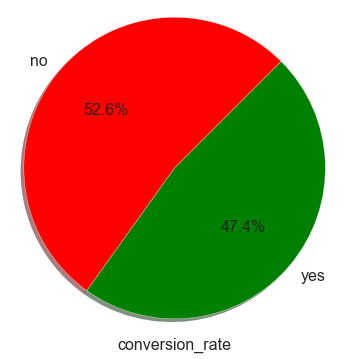

In [18]:
plt.figure(figsize=(6,6))

conversion_rate = a.index
count = a.values
colors= ['red','green']

plt.pie(count, labels=['no','yes'],
        shadow=True,
        colors=colors, 
        autopct='%1.1f%%',
        startangle=45,
        textprops={'fontsize': 16})

plt.xlabel('conversion_rate',fontsize=16)
plt.axis('equal')
plt.show()

In [19]:
X = df_new.drop('deposit',axis=1).copy()
y = df_new['deposit'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)


In [20]:
#insert 'deposit' pada X_train dan X_test untuk memudahkan 
X_train['deposit'] = y_train
X_test['deposit'] = y_test

In [21]:
info_data(X_train)

Number of Rows,Columns (7813, 14)
Number of Duplicated Values 0


,Missing_value,Percent_missing_%,Data_type,Number of Unique
age,0,0.0,int64,75
job,0,0.0,object,12
marital,0,0.0,object,3
education,0,0.0,object,4
default,0,0.0,object,2
balance,0,0.0,int64,3191
housing,0,0.0,object,2
loan,0,0.0,object,2
day,0,0.0,int64,31
month,0,0.0,object,12


#### Observation
1. total column = 14
2. total row = 7813 (70%data frame)

## 6. Descriptive Statistic

In [22]:
numerical = ['age','balance','day','campaign','pdays','previous']
categorical = ['month','loan','housing','default','education','marital','job']

In [23]:
#analisa numerical
X_train[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,7813.0,41.237169,11.850243,18.0,32.0,39.0,49.0,95.0
balance,7813.0,1536.787278,3215.999050,-3058.0,124.0,553.0,1730.0,81204.0
day,7813.0,15.605273,8.419817,1.0,8.0,15.0,21.0,31.0
campaign,7813.0,2.499552,2.722798,1.0,1.0,2.0,3.0,63.0
pdays,7813.0,49.952643,107.826919,-1.0,-1.0,-1.0,-1.0,854.0
previous,7813.0,0.802253,2.135139,0.0,0.0,0.0,0.0,41.0


#### Observation 
1. Rata-rata umur (`age`) nasabah adalah 41, umur minimal 18 dan umur maksimal 95.Data dapat dikatakan normal, karna masih ada manusia yang berumur 95<br/>
2. Rata-rata `balance` nasabah adalah 1536 dollar, `balance` minimal -3058 dollar, dan `balance` maksimal 81204 dollar. Tanda minus berarti nasabah memiliki hutang pada bank
3. Rata-rata tanggal last contact bank dan nasabah (`day`) dalam satu bulan adalah tanggal 15
4. Rata-rata jumlah `campaign` adalah 3, jumlah minimal 1 dan jumlah maksimal 63
5. 75% nasabah tidak pernah dikontak oleh bank (`pdays`=jumlah hari terakhir dikontak dan `previous`=jumlah kontak sebelum campaign). Maksud dari angka 0 dan -1 adalah tidak pernah dikontak. Untuk analisa selanjutnya, kita akan menggunakan feature baru `is_contact` untuk merepresentativkan feature `pdays` dan `previous` 

In [24]:
#analisa categorical
X_train[categorical].describe().T

,count,unique,top,freq
month,7813,12,may,1972
loan,7813,2,no,6770
housing,7813,2,no,4157
default,7813,2,no,7701
education,7813,4,secondary,3788
marital,7813,3,married,4431
job,7813,12,management,1819


#### Observation
1. Sebagian besar nasabah di terakhir hubungi bank pada bulan Mei (`month`)
2. Sebagian besar nasabah tidak memiliki pinjaman (`loan`),cicilan rumah (`housing`),serta tidak gagal bayar (`default`)
3. Sebagian besar nasabah memiliki level pendidikan secondary (`education`) dan berstatus sudah menikah (`marital`)
4. Sebagian besar nasabah memiliki level pekerjaan management (`job`)

## 7. Analisa Profil Nasabah

In [25]:
#catergoric vs categoric
#predictor,target
def category_category (i,j) :
    
    ax = ((X_train.groupby([i])[j].mean())/((X_train.groupby([i])[j].mean()).sum())*100).plot(kind='bar',figsize=(10,8))
    abs_values = round(((X_train.groupby([i])[j].mean())/((X_train.groupby([i])[j].mean()).sum())*100),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)  
    
    plt.xticks(rotation=0);
    plt.ylabel('Conversion Rate (%)',fontsize=12)
    plt.title(f'{i} vs Conversion Rate (%)',fontsize=12)
    plt.xlabel(i,fontsize=12)
    plt.ylim(0,100)
    
    plt.show()

In [26]:
#numerical vs categoric
#num,cat
def num_category (n,c) :
    ax = (X_train.groupby([c])[n].median()).plot(kind='bar',figsize=(10,8))
    abs_values = round((X_train.groupby([c])[n].median()),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    
    plt.title(f'{n} vs {c}',fontsize=12)
    plt.ylabel(c,fontsize=12)
    plt.xlabel(n,fontsize=12)
    plt.xticks(rotation=0);
    plt.ylim(0,max(abs_values)+100)
    plt.show()
    

### 7.1 Umur vs Conversion Rate 

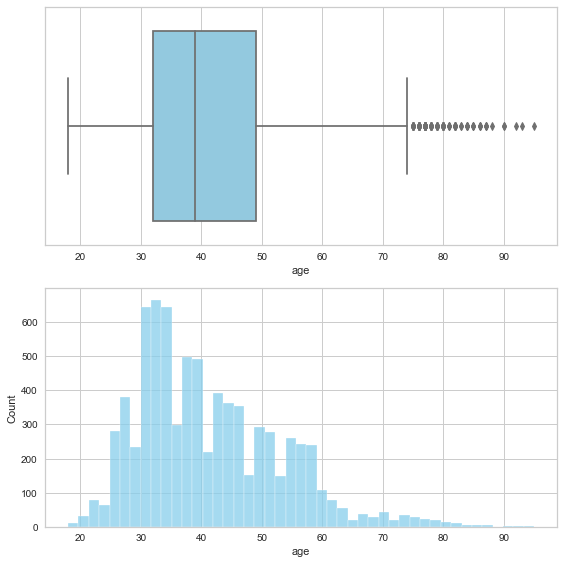

In [27]:
hist_boxplot(X_train,'age')

In [28]:
#cek outlier
X_train['outlier_age'] = outlier(X_train,'age')
X_train[X_train['outlier_age']=='outlier'].head(10)

 outlier lower limit : 6.5 
 outlier upper limit : 74.5


,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,deposit,outlier_age
3130,77,retired,married,tertiary,no,7802,no,no,1,feb,2,-1,0,1,outlier
1487,76,housemaid,divorced,primary,no,1411,no,no,15,apr,3,-1,0,1,outlier
3014,79,retired,married,primary,no,3025,no,no,11,dec,3,126,3,1,outlier
3945,84,retired,married,tertiary,no,4761,no,no,9,sep,1,92,3,1,outlier
1603,75,retired,married,tertiary,no,2991,no,no,22,apr,1,-1,0,1,outlier
2823,76,retired,married,secondary,no,4112,no,no,23,oct,2,-1,0,1,outlier
2885,76,retired,married,primary,no,1492,no,no,3,nov,1,-1,0,1,outlier
6227,75,retired,divorced,secondary,no,2199,no,no,13,nov,1,-1,0,0,outlier
5799,77,retired,divorced,primary,no,639,no,no,16,apr,7,-1,0,0,outlier
1582,95,retired,divorced,primary,no,2282,no,no,21,apr,17,-1,0,1,outlier


In [29]:
(X_train['outlier_age'].value_counts(normalize=True))*100

not-outlier    98.528094
outlier         1.471906
Name: outlier_age, dtype: float64

In [30]:
#drop feature outlier_age
X_train = X_train.drop('outlier_age',axis=1)

#### Observation 
Karna ada beberapa manusia yang berumur panjang yang memiliki umur sampai 95 tahun, sehingga data outlier feature `age` merupakan data yang masih make sense.Selain itu data outlier mengandung informasi pada feature lain, jadi data outlier pada feature `age` masih dipertahankan 

#### Observation
Kita akan menganalisa bagaimana pengaruh usia produktif dan tidak terhadap conversion rate dengan melakukan pengelompokan umur berdasarkan : <br/>
1. Rata-rata usia pensiun (60 ±) 
2. Usia produktif dan belum menikah (21-30)
3. Usia produktif dan sudah menikah (30~50)

In [31]:
#mengelompokkan umur 
def bin_age (x) :
    if x<=30 :
        return '21-30'
    elif x<=40 :
        return '31-40'
    elif x<=50 :
        return '41-50'
    elif x<=60 :
        return '51-60'  
    else :
        return '61+'

In [32]:
X_train['age_cat'] = X_train['age'].apply(bin_age)
X_train['age_cat'].unique()

array(['51-60', '31-40', '41-50', '21-30', '61+'], dtype=object)

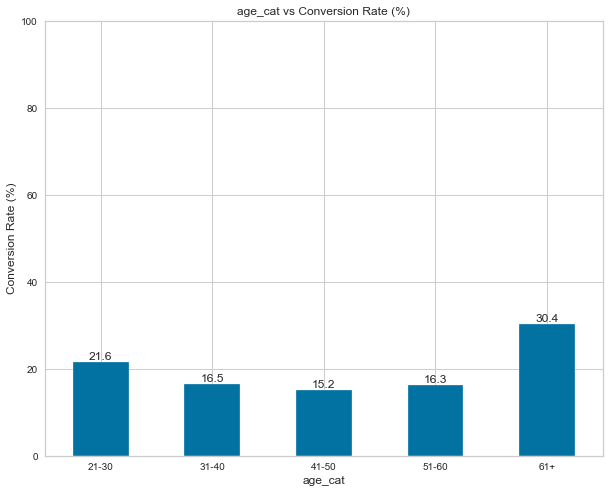

In [33]:
#hubungan umur dengan conversion rate
category_category('age_cat','deposit')

In [34]:
#uji statistik
annova_cek('age')

age
Kesimpulan : nilai p_value 0.006925639874187236 kurang dari alpha 0.05, nilai ftest = 7.296025947954262
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan barchat dan hasil uji statistik, dapat diketahui bahwa umur mempengaruhi conversion rate pembukaan deposit. Nasabah dengan usia pensiun yaitu kelompok umur 61+ memiliki kecenderungan membuka deposit paling besar dibandingkan yang lain (cr = 30.4%). Nasabah dengan usia produktif dan belum menikah memiliki kecenderungan membuka deposit lebih besar (cr usia 21-30 = 21.6% dan cr usia 31-40 = 16.5%) daripada nasabah dengan usia produktif tetapi sudah menikah (cr usia 41-60 = 15.2% dan cr usia 51-60 = 16.3%)

### 7.2  Balance vs Conversion Rate 

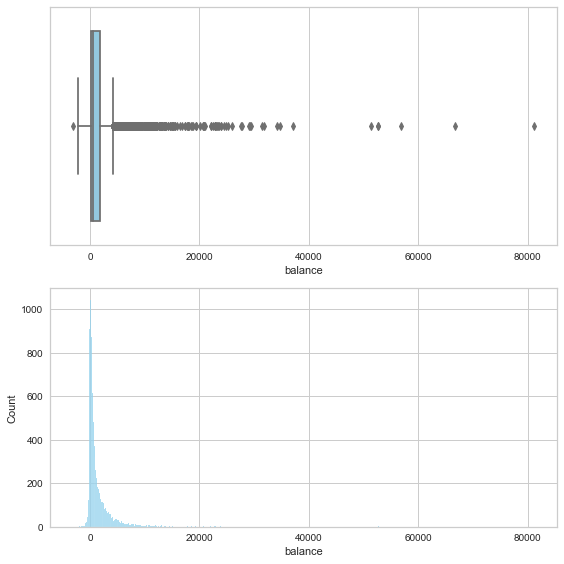

In [35]:
hist_boxplot(X_train,'balance')

In [36]:
#cek outlier
X_train['outlier_balance'] = outlier(X_train,'balance')
X_train[X_train['outlier_balance']=='outlier'].head(20)

 outlier lower limit : -2285.0 
 outlier upper limit : 4139.0


,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,deposit,age_cat,outlier_balance
812,46,technician,single,tertiary,no,4414,no,no,18,aug,7,-1,0,1,41-50,outlier
1092,28,unknown,single,secondary,no,4465,no,no,28,jan,1,-1,0,1,21-30,outlier
5339,49,entrepreneur,single,secondary,no,5802,no,no,12,aug,3,104,2,0,41-50,outlier
5426,53,management,divorced,tertiary,no,6388,yes,no,23,jul,2,-1,0,0,51-60,outlier
10629,28,self-employed,single,tertiary,no,5215,no,no,2,jun,1,-1,0,0,21-30,outlier
3130,77,retired,married,tertiary,no,7802,no,no,1,feb,2,-1,0,1,61+,outlier
4881,53,blue-collar,married,secondary,no,6112,no,no,3,feb,1,-1,0,1,51-60,outlier
10992,45,blue-collar,married,primary,no,6691,no,no,13,aug,2,-1,0,0,41-50,outlier
4401,34,management,single,unknown,no,6013,yes,no,18,may,1,-1,0,1,31-40,outlier
2362,28,management,single,tertiary,no,12956,yes,no,2,jul,1,399,3,1,21-30,outlier


In [37]:
(X_train['outlier_balance'].value_counts(normalize=True))*100

not-outlier    90.810188
outlier         9.189812
Name: outlier_balance, dtype: float64

#### Observation
Dari data outlier feature `balance`, kita dapat mengasumsikan bahwa ada beberapa nasabah yang memiliki status ekonomi lebih tinggi daripada rata-rata nasabah karna memiliki jumlah `balance` lebih besar daripada jumlah `balance` rata-rata nasabah. Sehingga data outlier feature `balance` merupakan data yang make sense. Selain itu data outlier mengandung informasi pada feature lain, jadi data outlier pada feature `balance` masih dipertahankan 

In [38]:
#drop outlier_balance
X_train = X_train.drop('outlier_balance',axis=1)

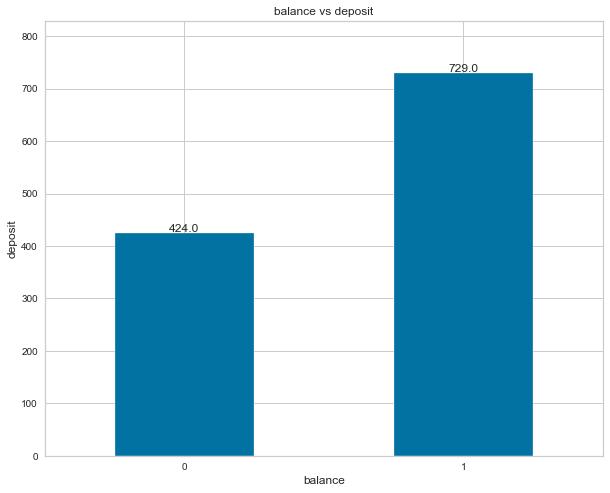

In [39]:
#hubungan balance dengan deposit 
num_category('balance','deposit')

In [40]:
annova_cek('balance')

balance
Kesimpulan : nilai p_value 2.2637765224193186e-10 kurang dari alpha 0.05, nilai ftest = 40.33095502390314
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Secara median,terdapat perbedaan 28.9% jumlah balance pada rekening nasabah yang cenderung membuka deposit dan tidak. Nasabah yang cenderung membuka deposit memiliki jumlah balance sebesar 729 dollar, sedangkan nasabah yang tidak membuka deposito hanya sebesar 424 dollar

### 7.3 Loan vs Conversion Rate 

#### 7.3.1 Personal Loan  vs Conversion Rate 

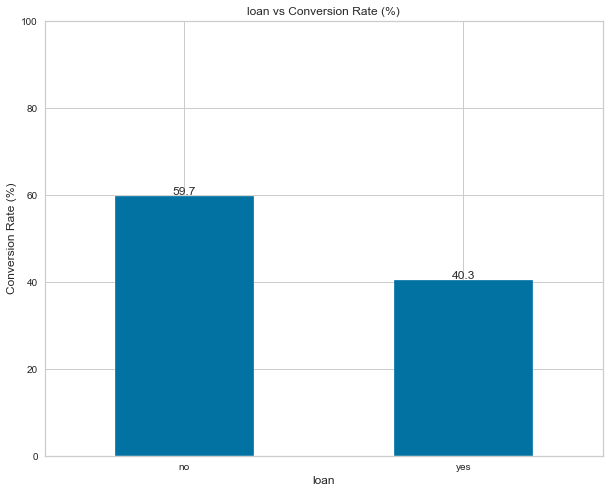

In [41]:
#hubungan personal loan dengan conversion rate
category_category('loan','deposit')

In [42]:
chi_cek('loan','deposit')

===== loan =====
Number Expected :
[[3579.53027006 3190.46972994]
 [ 551.46972994  491.53027006]]

Chi-square Statistic : 92.1189685795012 ,p-value: 8.16192772003411e-22 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan barchart dan hasil uji statistik, dapat diketahui bahwa personal loan mempengaruhi conversion rate. Nasabah yang tidak memiliki personal loan cenderung ingin membuka deposit (cr = 59.7%) dibandingkan nasabah yang memiliki pinjaman (cr=40.3%)

#### 7.3.2 Mortgage Loan  vs Conversion Rate 

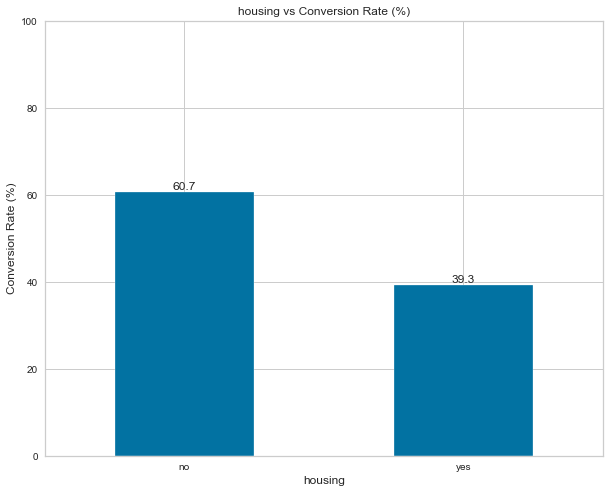

In [43]:
#hubungan mortage loan dengan conversion rate
category_category('housing','deposit')

In [44]:
chi_cek('housing','deposit')

===== housing =====
Number Expected :
[[2197.94790733 1959.05209267]
 [1933.05209267 1722.94790733]]

Chi-square Statistic : 306.5205996614736 ,p-value: 1.2508413757464674e-68 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan barchart dan hasil uji statistik, dapat diketahui bahwa nasabah yang tidak memiliki mortgage loan/cicilan rumah cenderung ingin membuka deposit (cr = 60.7%) dibandingkan nasabah yang memiliki cicilan rumah (cr=39.3%)

#### 7.3.3 Total Loan  vs Conversion Rate 

In [45]:
X_train['housing'] = X_train['housing'].replace(['yes','no'],[1,0])
X_train['loan'] = X_train['loan'].replace(['yes','no'],[1,0])
X_train['total_loan'] = X_train['housing'] + X_train['loan']
X_train['total_loan'].unique()

array([1, 0, 2], dtype=int64)

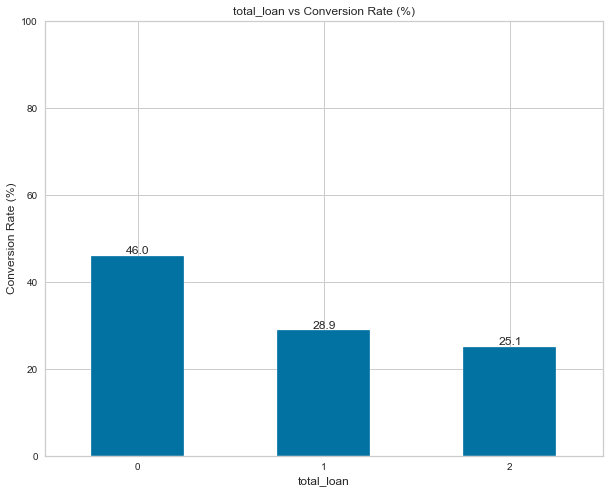

In [46]:
#hubungan total loan dengan conversion rate
category_category('total_loan','deposit')

In [47]:
chi_cek('total_loan','deposit')

===== total_loan =====
Number Expected :
[[1959.48880072 1746.51119928]
 [1858.50057596 1656.49942404]
 [ 313.01062332  278.98937668]]

Chi-square Statistic : 407.9979482372164 ,p-value: 2.5372965348986265e-89 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Dari analisa 7.3.1 dan 7.3.2, kita tahu bahwa nasabah yang tidak memiliki personal pinjaman dan cicilan rumah/mortgage loan cenderung ingin membuka deposit. 
Dan hal itu selaras dengan barchart hubungan total loan dan conversion rate, dimana semakin banyak jumlah pinjaman nasabah maka semakin kecil kecenderungan nasabah untuk membuka deposit

### 7.4 Gagal Bayar vs Conversion Rate 

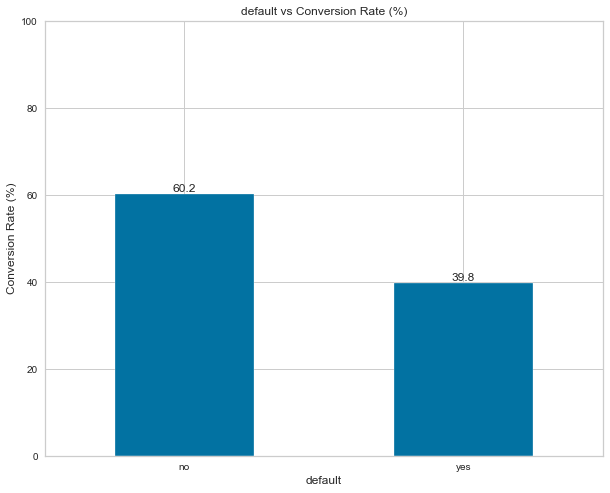

In [48]:
#hubungan gagal bayar dengan conversion rate
category_category('default','deposit')

In [49]:
chi_cek('default','deposit')

===== default =====
Number Expected :
[[4071.78177397 3629.21822603]
 [  59.21822603   52.78177397]]

Chi-square Statistic : 10.857403769812722 ,p-value: 0.0009840155129730744 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation 
Hasil uji statistik dan barchart menunjukkan bahwa gagal bayar memiliki pengaruh terhadap conversion rate. Nasabah yang pernah gagal bayar memiliki kecenderungan membuka deposit (cr = 39.8%) lebih rendah dibandingkan nasabah yang bayar tagihan tepat waktu (cr=60.2%)

### 7.5 Pendidikan vs Conversion Rate 

In [50]:
(X_train['education'].value_counts(normalize=True))*100

secondary    48.483297
tertiary     33.777038
primary      13.285550
unknown       4.454115
Name: education, dtype: float64

In [51]:
#replace unknown dgn modus (secondary)
X_train['education'] =X_train['education'].replace('unknown','secondary')

In [52]:
X_train['education'].value_counts()

secondary    4136
tertiary     2639
primary      1038
Name: education, dtype: int64

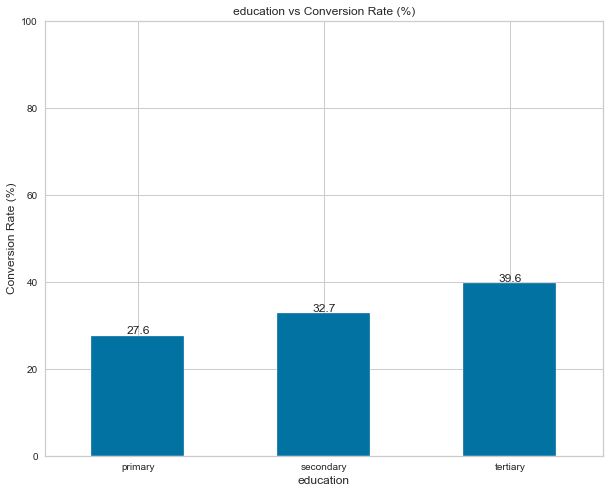

In [53]:
#hubungan education dengan conversion rate
category_category('education','deposit')

In [54]:
chi_cek('education','deposit')

===== education =====
Number Expected :
[[ 548.82605913  489.17394087]
 [2186.84448995 1949.15551005]
 [1395.32945092 1243.67054908]]

Chi-square Statistic : 99.45308699184167 ,p-value: 2.5353420272856645e-22 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Dari bachart dan hasil uji statistik, dapat disimpulkan bahwa pendidikan mempengaruhi conversion rate. Dimana semakin tinggi status pendidikan, semakin besar kecenderungan nasabah untuk membuka deposit. Convestion rate primary,secondary,tertiary adalah 27,6%, 32,7%, 39,7%

### 7.6 Pekerjaan vs Conversion Rate

In [55]:
(X_train['job'].value_counts(normalize=True))*100

management       23.281710
blue-collar      17.240497
technician       16.139767
admin.           11.788046
services          8.293869
retired           6.988353
self-employed     3.929349
student           3.186996
unemployed        3.161398
entrepreneur      2.713426
housemaid         2.598234
unknown           0.678357
Name: job, dtype: float64

In [56]:
##grouping job berdasarkan persentase counts (dibawah 5%)
X_train['job'] =X_train['job'].replace(['entrepreneur','self-employed','student','unemployed','housemaid','unknown'],
                                       ['other','other','other','other','other','other'])

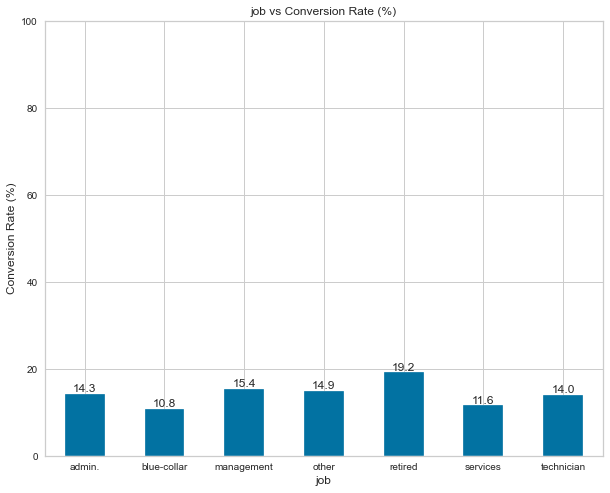

In [57]:
#hubungan pendidikan dengan conversion rate 
category_category('job','deposit')

In [58]:
chi_cek('job','deposit')

===== job =====
Number Expected :
[[486.96416229 434.03583771]
 [712.20491489 634.79508511]
 [961.76743888 857.23256112]
 [672.02111865 598.97888135]
 [288.68885191 257.31114809]
 [342.61973634 305.38026366]
 [666.73377704 594.26622296]]

Chi-square Statistic : 164.11517723037275 ,p-value: 7.95488044014975e-33 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Hasil uji statistik dan bachart menunjukan bahwa jenis pekerjaan memiliki pengaruh terhadap conversion rate. Nasabah  yang memiliki pekerjaan level management (cr=15.4%) dan seorang pensiunan (cr=19.2%) memiliki keinginan untuk membuka deposit lebih tinggi dibandingkan yang lain. Sedangkan konsumen yang bekerja sebagai blue-collar (cr=10.8%) dan service (cr=11.6%) cenderung tidak ingin membuka deposit

### 7.7 Status Pernikahan vs Conversion Rate

In [59]:
(X_train['marital'].value_counts(normalize=True))*100

married     56.713170
single      31.831563
divorced    11.455267
Name: marital, dtype: float64

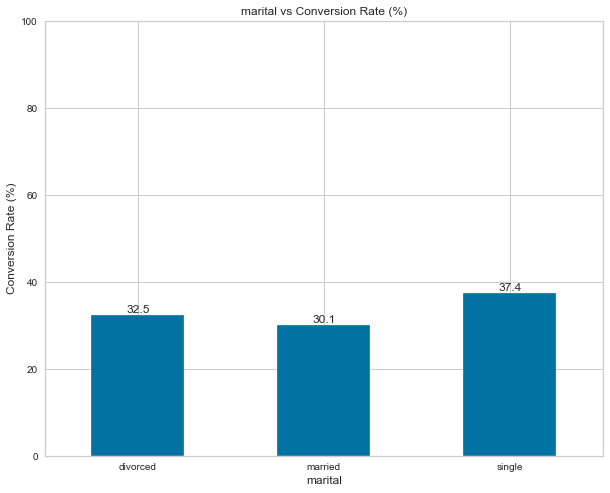

In [60]:
#hubungan status dengan conversion rate 
category_category('marital','deposit')

In [61]:
chi_cek('marital','deposit')

===== marital =====
Number Expected :
[[ 473.21707411  421.78292589]
 [2342.82106745 2088.17893255]
 [1314.96185844 1172.03814156]]

Chi-square Statistic : 71.11451867463643 ,p-value: 3.6114239862287743e-16 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan barchart dan hasil uji statistik, dapat diketahui bahwa nasabah belum menikah (37.3%) memiliki keinginan lebih besar membuka deposit dibandingkan yang sudah menikah(30.3%)/bercerai(32.4%)

## 8. Analisa Metode Campaign 

### 8.1 Jumlah Campaign vs Conversion Rate

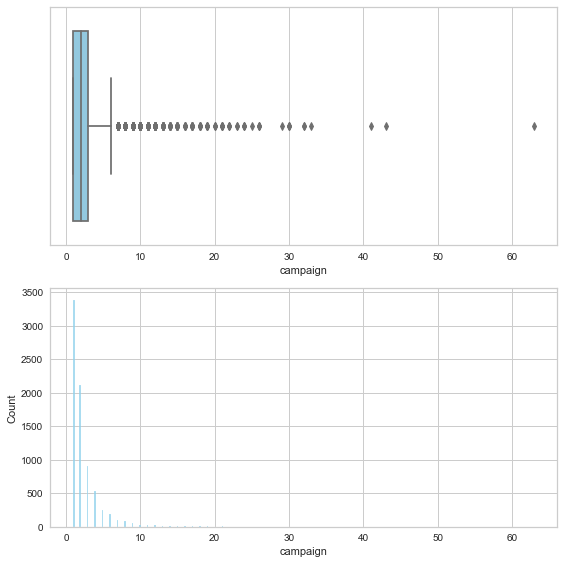

In [62]:
hist_boxplot(X_train,'campaign')

In [63]:
#cek outlier
X_train['outlier_campaign'] = outlier(X_train,'campaign')
X_train[X_train['outlier_campaign']=='outlier'].head(20)

 outlier lower limit : -2.0 
 outlier upper limit : 6.0


,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,deposit,age_cat,total_loan,outlier_campaign
361,41,blue-collar,single,secondary,no,75,1,0,1,jul,9,-1,0,1,41-50,1,outlier
812,46,technician,single,tertiary,no,4414,0,0,18,aug,7,-1,0,1,41-50,0,outlier
8388,55,technician,married,secondary,no,312,0,0,6,feb,8,9,3,0,51-60,0,outlier
4921,36,services,divorced,secondary,yes,0,0,1,15,jul,7,-1,0,1,31-40,1,outlier
1044,39,admin.,single,secondary,no,2263,1,1,21,nov,9,-1,0,1,31-40,2,outlier
618,46,other,married,secondary,no,271,1,0,30,jul,29,-1,0,1,41-50,1,outlier
4338,27,services,married,secondary,no,0,1,0,22,jul,13,-1,0,1,21-30,1,outlier
7116,36,admin.,single,secondary,no,1328,0,0,30,jul,9,-1,0,0,31-40,0,outlier
7888,37,technician,married,secondary,no,1580,0,0,22,aug,12,-1,0,0,31-40,0,outlier
8231,54,other,married,primary,no,3151,0,0,18,jun,7,-1,0,0,51-60,0,outlier


In [64]:
(X_train['outlier_campaign'].value_counts(normalize=True))*100

not-outlier    94.637143
outlier         5.362857
Name: outlier_campaign, dtype: float64

#### Observation 
Berdasarkan data oulier feature `campaign`, kita dapat mengetahui bahwa bank melakukan jumlah campaign yang berbeda kepada  setiap nasabah. Ada yang melakukan `campaign` tidak sampai 6x, tetapi ada beberapa nasabah yang dihubungi lebih dari 6x, misal 30x. Karna tidak ada informasi mengenai periode `campaign` dan lama masa tenure nasabah, maka kita dapat mengasumsikan bahwa periode `campaign` terjadi dalam waktu yang cukup lama dan nasabah yang dihubungi lebih dari 6x merupakan nasabah dengan masa tenure lama sehingga data outlier feature `campaign` adalah data yang make sense. Selain itu data outlier mengandung informasi pada feature lain, jadi data outlier pada feature `campaign` akan dipertahankan  

In [65]:
#drop feature outlier_campaign
X_train = X_train.drop('outlier_campaign',axis=1)

In [66]:
#cek persentase setiap unique value
(X_train['campaign'].value_counts(normalize=True))*100

1     43.338026
2     27.006272
3     11.672853
4      6.885959
5      3.238193
6      2.495840
7      1.241521
8      1.139127
9      0.716754
10     0.396775
11     0.319980
12     0.319980
13     0.230385
15     0.140791
14     0.140791
17     0.115193
16     0.076795
18     0.076795
21     0.063996
19     0.063996
26     0.038398
24     0.038398
22     0.038398
20     0.038398
30     0.038398
23     0.025598
32     0.025598
41     0.012799
63     0.012799
29     0.012799
33     0.012799
25     0.012799
43     0.012799
Name: campaign, dtype: float64

In [67]:
annova_cek ('campaign')

campaign
Kesimpulan : nilai p_value 7.863555840234008e-29 kurang dari alpha 0.05, nilai ftest = 125.13642629760876
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan hasil uji statistik, jumlah campaign mempengaruhi conversion rate. Selanjutnya, kita akan melakukan pengelompokan jumlah campaign karna jumlah unique value pada feature campaign terlalu banyak agar memudahkan analisa. Berikut adalah pengolompokan jumlah campaign :
1. 1-3x 
2. 4-6x
3. lebih dari 7x 

In [68]:
#mengelompokkan jumlah campaign

def bin_campaign (x) :
    if x<=3 :
        return '1-3'
    elif x<=6 :
        return '4-6'
    else :
        return '7+'

In [69]:
X_train['campaign_cat'] = X_train['campaign'].apply(bin_campaign)
X_train['campaign_cat'].unique()

array(['1-3', '7+', '4-6'], dtype=object)

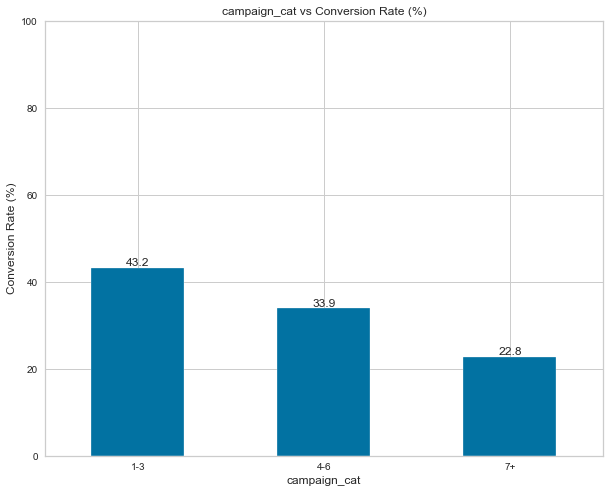

In [70]:
#hubungan jumlah campaign dengan conversion rate
category_category('campaign_cat','deposit')

#### Observation 
Berdasarkan barchar diatas, dapat diketahui semakin banyak kita melakukan campaign kepada nasabah, maka semakin menurun persentase conversion rate, hal ini dapat terjadi karna mungkin nasabah merasa terganggu apabila kita sering menghubungi mereka untuk promosi. Jumlah campaign yang paling optimal adalah 1-3x (cr=43.2%)

### 8.2 Last Contact (Quarter) vs Convertion Rate

In [71]:
X_train['month'].unique()

array(['jul', 'apr', 'aug', 'jan', 'feb', 'may', 'oct', 'jun', 'nov',
       'sep', 'mar', 'dec'], dtype=object)

In [72]:
quarter_dict = {
    'jan' : '1Q',
    'feb' : '1Q',
    'mar' : '1Q', 
    'apr' : '2Q', 
    'may' : '2Q',
    'jun' : '2Q',
    'jul' : '3Q', 
    'aug' : '3Q',
    'sep' : '3Q', 
    'oct' : '4Q', 
    'nov' : '4Q',
    'dec' : '4Q'}

In [73]:
X_train['quarter'] = X_train['month'].map(quarter_dict)
X_train['quarter'].unique()

array(['3Q', '2Q', '1Q', '4Q'], dtype=object)

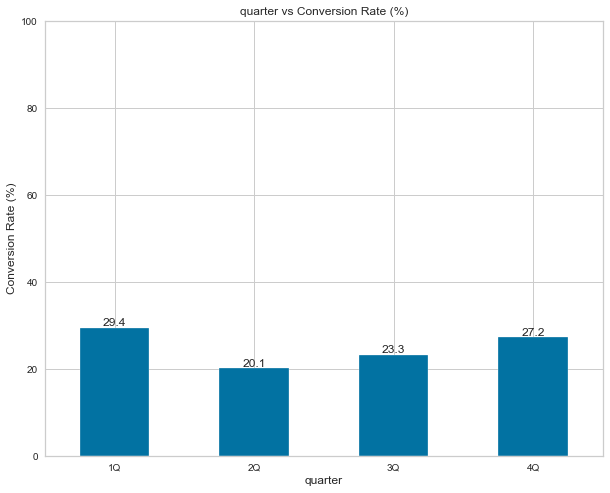

In [74]:
#hubungan last contact(quarter) dengan conversion rate
category_category('quarter','deposit')

In [75]:
chi_cek ('quarter','deposit')

===== quarter =====
Number Expected :
[[ 508.11352873  452.88647127]
 [1822.01791885 1623.98208115]
 [1259.9735057  1123.0264943 ]
 [ 540.89504672  482.10495328]]

Chi-square Statistic : 141.92489092384753 ,p-value: 1.4534469560257042e-30 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation 
Berdasarkan barchar diatas, dapat diketahui bahwa jika menghubungi nasabah pada awal tahun (1Q) dan akhir tahun (4Q), nasabah cenderung ingin membuka deposito dibandingkan ketika menghubungi di pertengahan tahun (3Q dan 2Q)

### 8.3 Last Contact (Week) vs Conversion Rate

In [76]:
X_train['day'].unique()

array([ 9, 13,  1, 18, 28,  6,  4,  3, 15, 12, 29, 21, 27,  7, 22,  2,  5,
       23, 30, 11, 17, 26, 25, 20, 16, 19,  8, 10, 24, 14, 31],
      dtype=int64)

In [77]:
annova_cek('day')

day
Kesimpulan : nilai p_value 4.9521482197415715e-06 kurang dari alpha 0.05, nilai ftest = 20.884911802197184
Terdapat perbedaan target yang signifikan dari segi predictor



Berdasarkan hasil uji statistik, tanggal last contact mempengaruhi conversion rate. Selanjutnya, kita akan melakukan pengelompokan tanggal menjadi perminggu karna jumlah unique value pada feature `day` terlalu banyak agar memudahkan analisa

In [78]:
#mengelompokkan tanggal

def bin_day (x) :
    if x<=7 :
        return '1W'
    elif x<=14 :
        return '2W'
    elif x<=21 :
        return '3W'
    else :
        return '4W'

In [79]:
X_train['week'] = X_train['day'].apply(bin_day)
X_train['week'].unique()

array(['2W', '1W', '3W', '4W'], dtype=object)

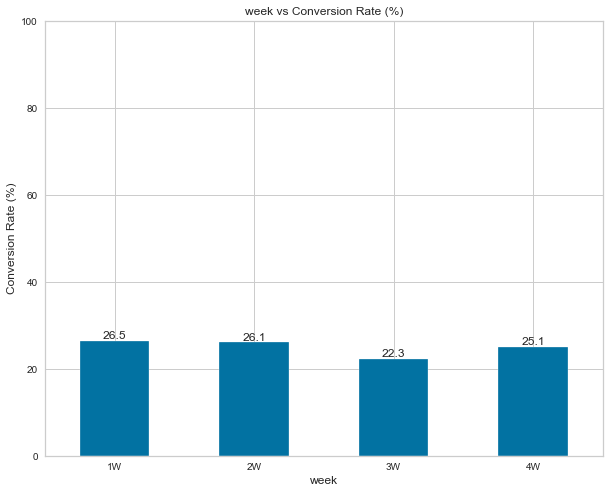

In [80]:
#hubungan last contact dengan conversion rate
category_category('week','deposit')

In [81]:
chi_cek('week','deposit')

===== week =====
Number Expected :
[[ 932.15832587  830.84167413]
 [ 972.87085627  867.12914373]
 [1197.5828747  1067.4171253 ]
 [1028.38794317  916.61205683]]

Chi-square Statistic : 32.07707842940345 ,p-value: 5.041323674964882e-07 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation 
Berdasarkan barchar diatas, dapat diketahui bahwa jika menghubungi nasabah pada 2 minggu pertama dalam satu bulan (1W dan 2W), nasabah cenderung ingin membuka deposito dibandingkan ketika menghubungi di 2 minggu terakhir (4W dan 3W)

### 8.4 Kontak Sebelum Campaign vs Conversion Rate

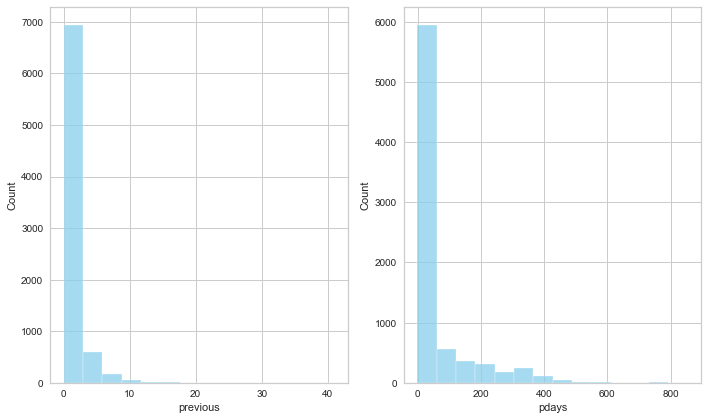

In [82]:
plt.figure(figsize=(10,6))
plt.subplot(121)
sns.histplot(X_train['previous'],color='skyblue')

plt.subplot(122)
sns.histplot(X_train['pdays'],color='skyblue')
plt.tight_layout()

In [83]:
annova_cek ('previous')

previous
Kesimpulan : nilai p_value 4.700433310523744e-40 kurang dari alpha 0.05, nilai ftest = 177.4786270899264
Terdapat perbedaan target yang signifikan dari segi predictor



In [84]:
annova_cek ('pdays')

pdays
Kesimpulan : nilai p_value 1.271439480934147e-45 kurang dari alpha 0.05, nilai ftest = 203.60904227204293
Terdapat perbedaan target yang signifikan dari segi predictor



In [85]:
((X_train['previous'].value_counts(normalize=True))*100).sort_index(ascending=True).head(5)

0    75.092794
1     7.820300
2     5.977217
3     3.942148
4     2.137463
Name: previous, dtype: float64

In [86]:
((X_train['pdays'].value_counts(normalize=True))*100).sort_index(ascending=True).head(5)

-1    75.092794
 1     0.076795
 2     0.076795
 4     0.012799
 5     0.025598
Name: pdays, dtype: float64

#### Observation 
Feature `previous` adalah jumlah kontak antara nasabah dan bank sebelum current `campaign` terjadi. Sedangkan, feature `pdays` adalah jumlah hari terakhir kontak antara nasabah dan bank sebelum current `campaign` terjadi. Maksud dari 0 pada feature `previous` dan -1 pada feature `pdays` adalah tidak pernah ada kontak antara nasabah dan bank. Karna 75% nasabah tidak pernah kontak dengan bank, maka untuk analisa selanjutnya kita akan menggunakan feature baru yaitu `is_contact` untuk merepresentativkan feature `pdays` dan `previous`. Kita akan membuat feature `is_contact` dengan menggunakan informasi pada feature `pdays` karna nilai p-value lebih kecil daripada nilai p-value `previous` 

In [87]:
X_train['is_contact'] = X_train['pdays'].apply(lambda x : 0 if x<=0 else 1)

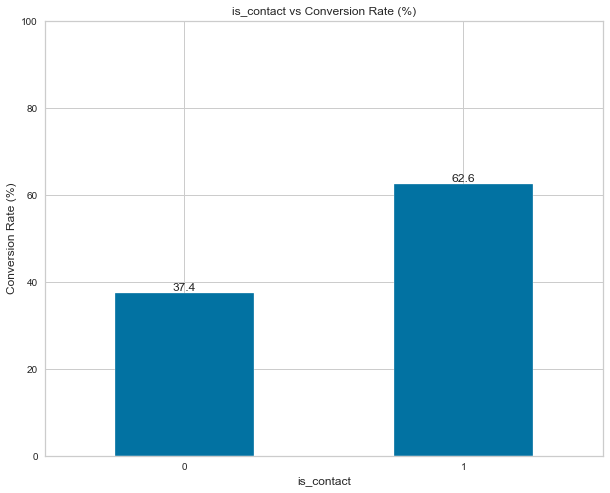

In [88]:
#hubungan last contact dengan conversion rate
category_category('is_contact','deposit')

In [89]:
chi_cek ('is_contact','deposit')

===== is_contact =====
Number Expected :
[[3102.08332267 2764.91667733]
 [1028.91667733  917.08332267]]

Chi-square Statistic : 431.5781049889739 ,p-value: 7.3691106160784495e-96 kurang dari 0.05 
Terdapat perbedaan target yang signifikan dari segi predictor



#### Observation
Berdasarkan barchar diatas, dapat diketahui bahwa nasabah yang dihubungi sebelum campaign berjalan cenderung ingin membuka deposit daripada yang tidak dihubungi oleh bank

## 9. Deep-dive Question Analysis

1. Bagaimana status pernikahan nasabah setiap kategori umur?
2. Apa penyebab nasabah yang belum menikah memiliki kecenderungan subscribe deposit?
3. Apa penyebab nasabah kelompok umur 61+ memiliki conversion rate paling tinggi meskipun sudah banyak yang menikah?
4. Apa penyebab nasabah yang sudah pensiun dan bekerja dibidang management memiliki conversion rate yang tinggi?
5. Apa mayoritas pekerjaan nasabah kelompok 61+ dan kelompok 21-30?
6. Apakah pendidikan adalah alasan nasabah perkelompok umur untuk subscribe deposit?

## 9.1 Bagaimana status pernikahan nasabah setiap kategori umur?

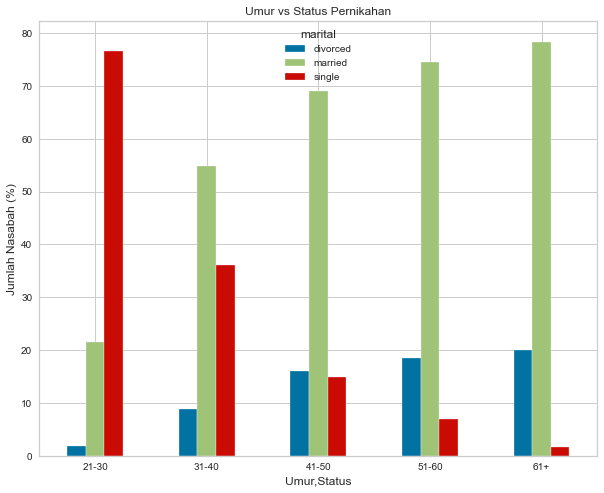

In [90]:
((pd.crosstab(X_train['age_cat'],X_train['marital']).apply(lambda x:x/x.sum(),axis=1))*100).plot(kind='bar',figsize=(10,8))
plt.title('Umur vs Status Pernikahan',fontsize=12) 
plt.xlabel('Umur,Status',fontsize=12)
plt.ylabel('Jumlah Nasabah (%)',fontsize=12)
plt.xticks(rotation=0);

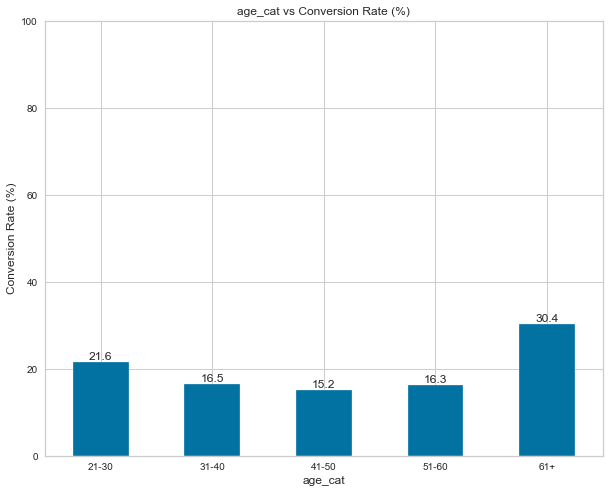

In [91]:
category_category('age_cat','deposit')

#### Observation

Menurut analisa 7.7 Status Pernikahan vs Conversion Rate,nasabah yang belum menikah memiliki kecenderungan subscribe deposit lebih tinggi dibandingkan nasabah yang sudah menikah. Lalu berdasarkan 2 barchart diatas, kita tahu bahwa :

1. Semakin bertambahnya umur, semakin banyak nasabah yang sudah menikah. 
2. Kelompok umur 61+ dan 21-30 adalah kelompok nasabah yang memiliki kecenderungan subscribe deposit paling tinggi dibandingkan kelompok lainnya
3. Kelompok umur 61+ adalah nasabah-nasabah yang sudah menikah
4. Kelompok umur 21-30 adalah nasabah-nasabah yang belum menikah 

<br/>
Dari 4 poin diatas, muncul pertanyaan (1) Apa penyebab nasabah yang belum menikah memiliki conversion rate tinggi? (2) Apa penyebab nasabah umur 61+ memiliki conversion rate tinggi meski banyak yang sudah menikah?. 2 pertanyaan tersebut akan kita bahas pada bahasan selanjutnya. 

## 9.2 Apa penyebab nasabah yang belum menikah memiliki kecenderungan subscribe deposit?

In [92]:
from functools import reduce
def predictor_marital (i,j='marital') : 
    a0 = pd.crosstab(X_train[i],X_train[j]).unstack(level=1).reset_index()
    a1 = a0
    
    #filter tabel berdasarkan 0 dan 1
    a0 = a0[a0[i]==0]
    a1 = a1[a1[i]==1]
    
    #ganti kolom 0 sesuai 0 dan 1 tiap table
    a0 = a0.rename(columns={0:'count0'})
    a1 = a1.rename(columns={0:'count1'})
    
    #drop kolom feature tiap table
    a0 = a0.drop(i,axis=1)
    a1 = a1.drop(i,axis=1)
    
    #gabungkan tabel
    total = [a0,a1]
    final = reduce(lambda left,right: pd.merge(left,right,on=['marital'],
                                                how='outer'), total)
    
    #hitung persentase nasabah 0 dari jumlah total 0 dan 1 tiap kategori umur
    final['sum'] = (final['count0']+final['count1'])
    final['percent_count0'] = round(((final['count0']/final['sum'])*100),2)
    
    #hitung persentase nasabah 0 dari jumlah total persentase nasabah 0 
    final['percent_final'] = round(((final['percent_count0']/final['percent_count0'].sum())*100),1)
    
    #membuat barplot
    plt.figure(figsize=(10,8))
    ax = sns.barplot(data=final, x='marital', y='percent_count0',errwidth=0)
    plt.xlabel('Status Pernikahan')
    plt.ylim (0,110)
    
    for x in ax.containers :
        ax.bar_label(x,)
    
    if i=='loan' : 
        plt.title(f'Jumlah Nasabah Tidak Memiliki Pinjaman Pribadi (%) vs Status Pernikahan')
        plt.ylabel('Jumlah Nasabah Tidak Memiliki Pinjaman Pribadi (%)')
    
    if i=='housing' : 
        plt.title(f'Jumlah Nasabah Tidak Memiliki Cicilan Rumah (%) vs Status Pernikahan')
        plt.ylabel('Jumlah Nasabah Tidak Memiliki Cicilan Rumah (%)')
   
    elif i=='default' : 
        plt.title(f'Jumlah Nasabah Tidak Gagal Bayar (%) vs Status Pernikahan')
        plt.ylabel('Jumlah Nasabah Tidak Gagal Bayar (%)')

In [93]:
X_train['default'] = X_train['default'].replace(['yes','no'],[1,0])

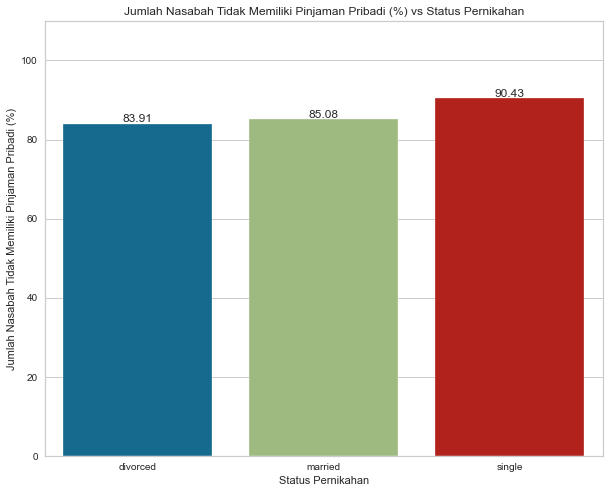

In [94]:
predictor_marital('loan')

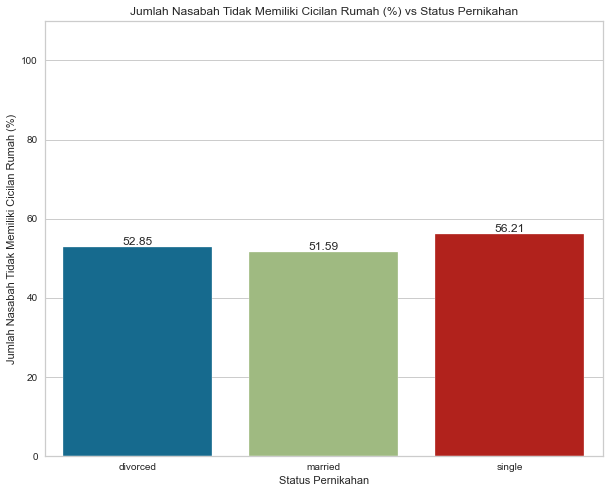

In [95]:
predictor_marital('housing')

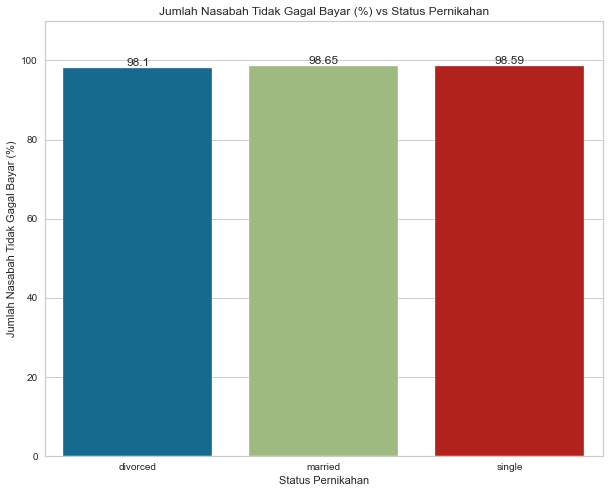

In [96]:
predictor_marital('default')

#### Observation
Berdasarkan analisa 7.3 Loan vs Conversion Rate dan 7.4 Gagal Bayar vs Conversion Rate, kita tahu bahwa nasabah yang tidak gagal bayar dan tidak memiliki pinjaman baik cicilan rumah atau pinjaman pribadi cenderung ingin membuka deposit.Lalu dari 3 barchart diatas, dapat diketahui : <br/>
1. Hampir semua nasabah adalah nasabah yang tidak pernah gagal bayar
2. Nasabah single adalah nasabah yang paling sedikit memiliki cicilan rumah dan pinjaman pribadi. Hal ini masuk akal mengapa nasabah single memiliki kecenderungan subscribe deposit paling tinggi 

## 9.3 Apa penyebab nasabah kelompok umur 61+ memiliki conversion rate paling tinggi meskipun sudah banyak yang menikah?

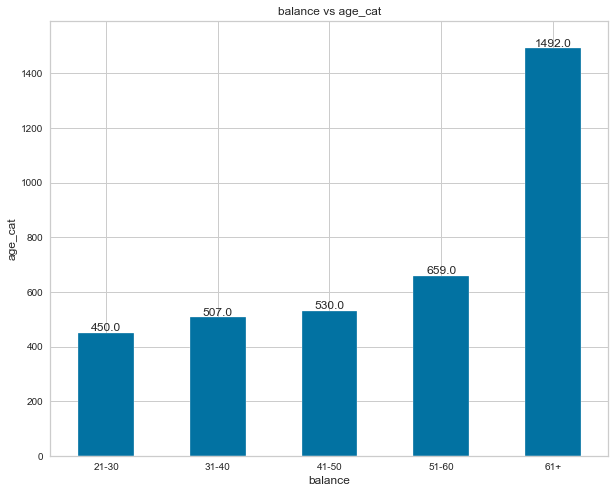

In [97]:
num_category('balance','age_cat')

#### Observation
Berdasarkan barchart diatas, kita tahu bahwa nasabah kelompok umur 61+ memiliki jumlah balance yang berbeda signifikan dibandingkan kelompok lainnya. Lalu, menurut analisa 7.2 Balance vs Conversion Rate, nasabah yang cenderung subscribe deposit memiliki jumlah balance lebih banyak daripada yang tidak subscribe. Hal ini menjadi masuk akal mengapa nasabah kelompok umur 61+ memiliki conversion rate paling tinggi dibandingkan kelompok lainnya meskipun sudah menikah

## 9.4 Apa penyebab nasabah yang sudah pensiun dan bekerja dibidang management memiliki conversion rate yang tinggi?

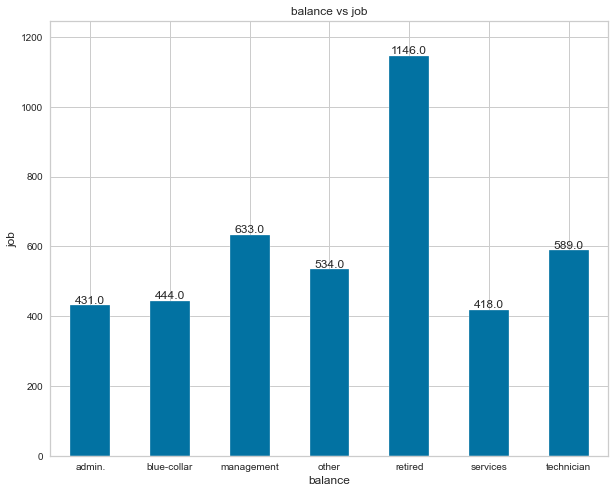

In [98]:
num_category('balance','job')

#### Observation
Berdasarkan barchart diatas, dapat diketahui bahwa nasabah yang bekerja dibidang management dan seorang pensiunan memiliki jumlah balance lebih tinggi dibandingnkan nasabah dengan pekerjaan lainnya karna memiliki jumlah balance lebih tinggi, hal ini selaras dengan informasi 7.2 Balance vs Conversion Rate, dimana nasabah dengan jumlah balance yang lebih tinggi cenderung membuka deposit.


## 9.5. Apa mayoritas pekerjaan nasabah kelompok 61+ dan kelompok 21-30?

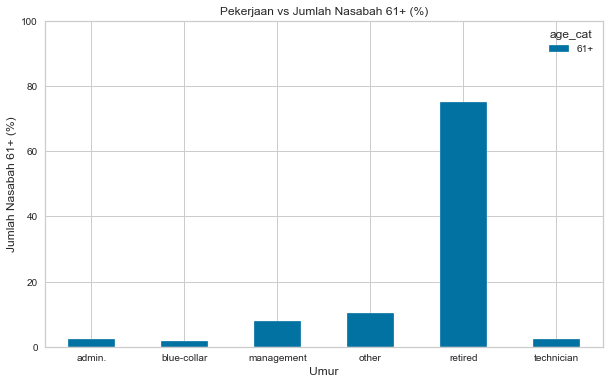

In [99]:
((pd.crosstab(X_train['job'],X_train[X_train['age_cat']=='61+']['age_cat']).apply(lambda x : x/x.sum(),axis=0))*100).plot(kind='bar',figsize=(10,6))
plt.title('Pekerjaan vs Jumlah Nasabah 61+ (%)',fontsize=12) 
plt.xlabel('Umur',fontsize=12)
plt.ylabel('Jumlah Nasabah 61+ (%)',fontsize=12)
plt.ylim(0,100)
plt.xticks(rotation=0);

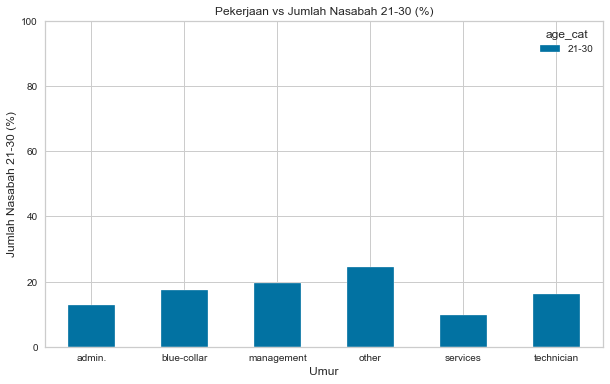

In [100]:
((pd.crosstab(X_train['job'],X_train[X_train['age_cat']=='21-30']['age_cat']).apply(lambda x : x/x.sum(),axis=0))*100).plot(kind='bar',figsize=(10,6))
plt.title('Pekerjaan vs Jumlah Nasabah 21-30 (%)',fontsize=12) 
plt.xlabel('Umur',fontsize=12)
plt.ylabel('Jumlah Nasabah 21-30 (%)',fontsize=12)
plt.ylim(0,100)
plt.xticks(rotation=0);

#### Observation 
1. Pekerjaan nasabah kelompok umur 61+ : pensiunan
2. Pekerjaan nasabah kelompok umur 21-30 : management

## 9.6 Apakah pendidikan adalah alasan nasabah perkelompok umur untuk subscribe deposit?

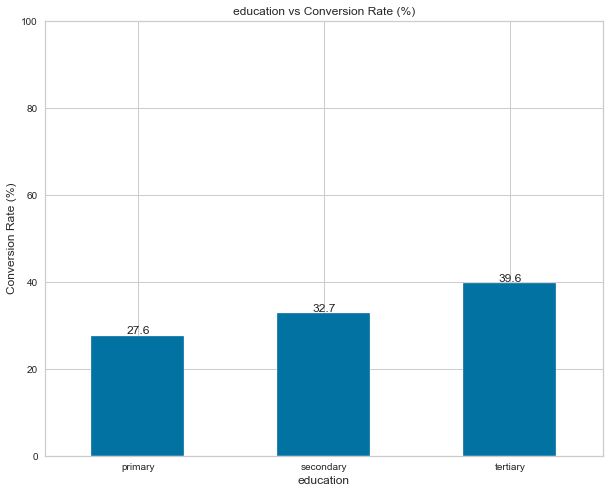

In [101]:
category_category('education','deposit')

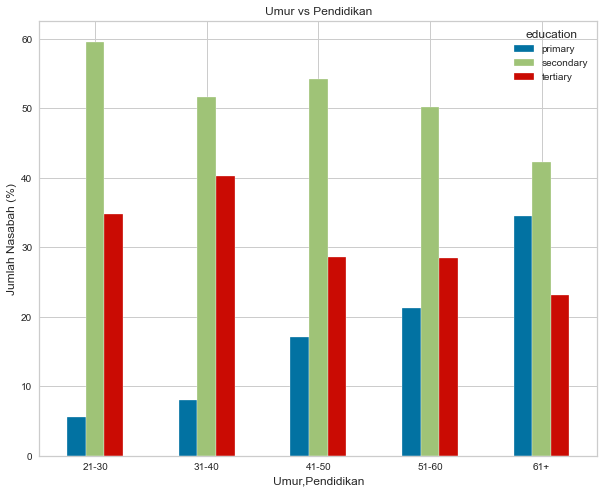

In [102]:
((pd.crosstab(X_train['age_cat'],X_train['education']).apply(lambda x:x/x.sum(),axis=1))*100).plot(kind='bar',figsize=(10,8))
plt.title('Umur vs Pendidikan',fontsize=12) 
plt.xlabel('Umur,Pendidikan',fontsize=12)
plt.ylabel('Jumlah Nasabah (%)',fontsize=12)
plt.xticks(rotation=0);

#### Observation 
Berdasarkan 2 barchart diatas dapat disimpulkan bahwa pendidikan bukan alasan nasabah perkelompok umur untuk subscribe deposit karna sebagian besar pendidikan nasabah perkelompok umur adalah secondary bukan tertiary

# Data Preprosesing

In [103]:
info_data(X_train)

Number of Rows,Columns (7813, 20)
Number of Duplicated Values 0


,Missing_value,Percent_missing_%,Data_type,Number of Unique
age,0,0.0,int64,75
job,0,0.0,object,7
week,0,0.0,object,4
quarter,0,0.0,object,4
campaign_cat,0,0.0,object,3
total_loan,0,0.0,int64,3
age_cat,0,0.0,object,5
deposit,0,0.0,int64,2
previous,0,0.0,int64,28
pdays,0,0.0,int64,431


## 10.  Data Preprocessing - Train 

In [104]:
#rank encoding
X_train['month'] = X_train['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],[1,2,3,4,5,6,7,8,9,10,11,12])
X_train['week'] = X_train['week'].replace(['1W','2W','3W','4W'],[1,2,3,4])
X_train['quarter'] = X_train['quarter'].replace(['1Q','2Q','3Q','4Q'],[1,2,3,4])
X_train['campaign_cat'] = X_train['campaign_cat'].replace(['1-3','4-6','7+'],[0,1,2])
X_train['age_cat'] = X_train['age_cat'].replace(['21-30','31-40','41-50','51-60','61+'],[0,1,2,3,4])

#one hot encoding
X_train= pd.get_dummies(X_train,columns=['job','education','marital'])

## 11. Feature Selection

Text(0.5, 1.0, 'Correlation Matrix')

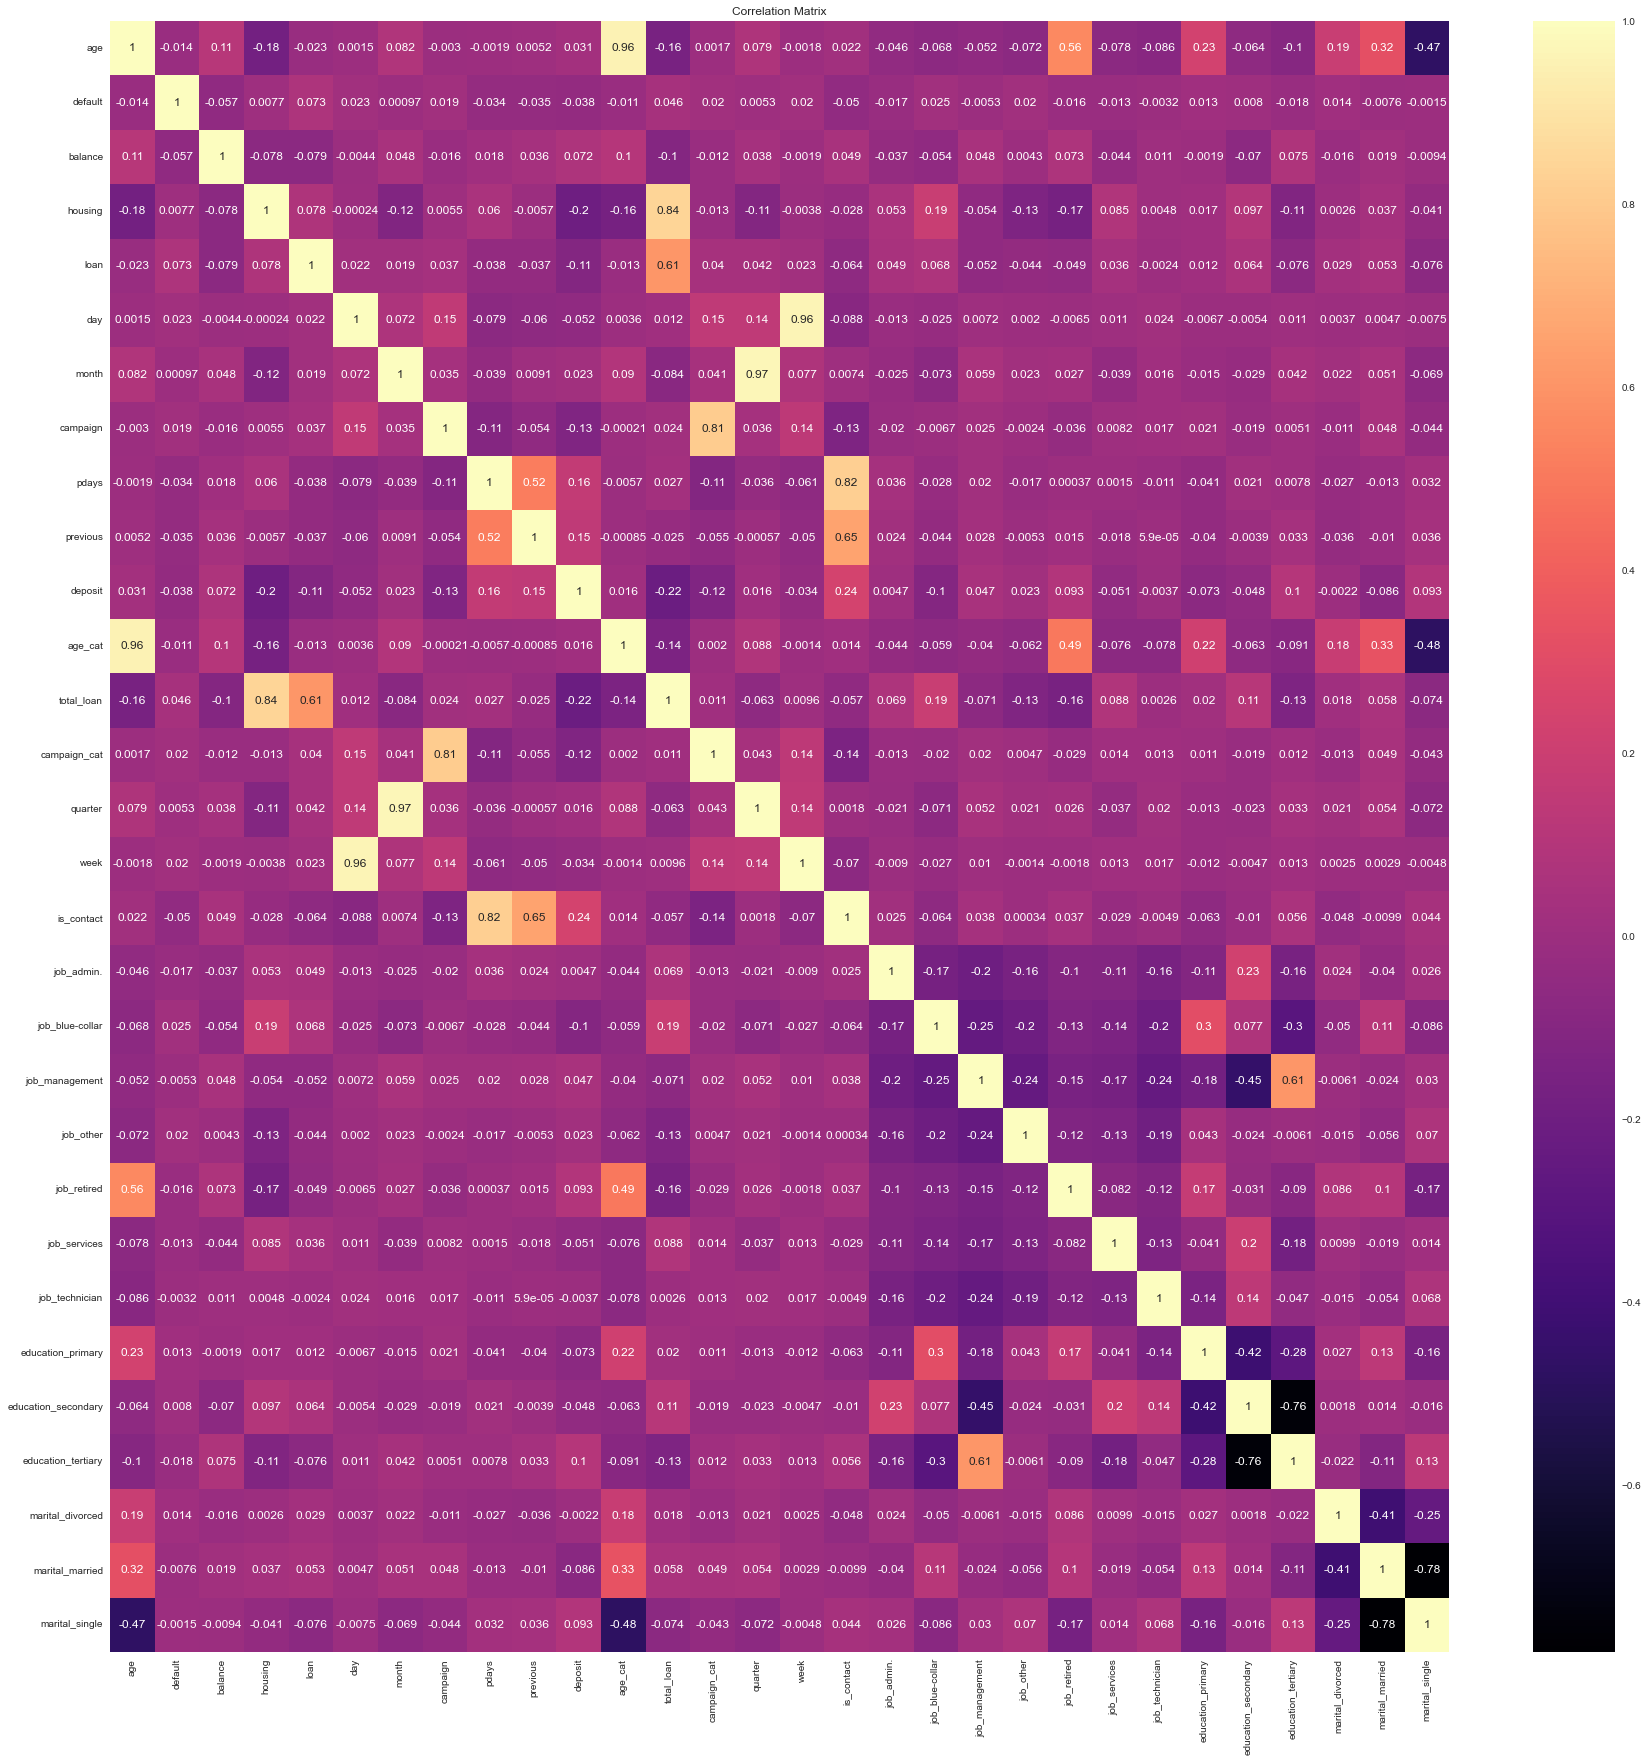

In [105]:
plt.figure(figsize=(30,30))
sns.heatmap(X_train.corr(), annot = True,
           fmt='.2g', cmap='magma')
plt.title('Correlation Matrix',fontsize = 12)

#### Observation 
Berikut adalah nilai korelasi antara 2 feature (abs value) : <br/>
1. `age` dan `age_cat` memiiki korelasi tinggi 0.96. `age` dan target `deposit` memiliki korelasi 0.031 sedangkan `age_cat` dan `deposit` memiliki korelasi 0.016. Maka kita akan drop `age_cat`
2. `day` dan `week` memiiki korelasi tinggi 0.96. `day` dan target `deposit` memiliki korelasi 0.052 sedangkan `week` dan `deposit` memiliki korelasi 0.034. Maka kita akan drop `week`
3. `housing` dan `total_loan` memiiki korelasi tinggi 084. `housing` dan target `deposit` memiliki korelasi 0.2 sedangkan `total_loan` dan `deposit` memiliki korelasi 0.22. Maka kita akan drop `housing`
4. `month` dan `quarter` memiiki korelasi tinggi 0.97. `month` dan target `deposit` memiliki korelasi 0.023 sedangkan `quarter` dan `deposit` memiliki korelasi 0.016. Maka kita akan drop `quarter`
5. `campaign` dan `campaign_cat` memiiki korelasi tinggi 0.81. `campaign` dan target `deposit` memiliki korelasi 0.13 sedangkan `campaign_cat` dan `deposit` memiliki korelasi 0.12. Maka kita akan drop `campaign_cat`
6. `pdays` dan `is_contact` memiiki korelasi tinggi 0.82. `pdays` dan target `deposit` memiliki korelasi 0.16 sedangkan `is_contact` dan `deposit` memiliki korelasi 0.24. Maka kita akan drop `pdays`
7. `education_secondary` dan `education_tertiary` memiiki korelasi tinggi 0.76. `education_secondary` dan target `deposit` memiliki korelasi 0.048 sedangkan `education_tertiary` dan `deposit` memiliki korelasi 0.1. Maka kita akan drop `education_secondary`
8. `marital_married` dan `marital_single` memiiki korelasi tinggi 0.78. `marital_married` dan target `deposit` memiliki korelasi 0.086 sedangkan `marital_single` dan `deposit` memiliki korelasi 0.93. Maka kita akan drop `marital_married`


In [106]:
X_train = X_train.drop(['age_cat','week','housing','quarter','campaign_cat','pdays','education_secondary','marital_married','deposit'],axis=1)

## 12. Data Preprocessing - Test

In [107]:
info_data(X_test)

Number of Rows,Columns (3349, 14)
Number of Duplicated Values 1


,Missing_value,Percent_missing_%,Data_type,Number of Unique
age,0,0.0,int64,74
job,0,0.0,object,12
marital,0,0.0,object,3
education,0,0.0,object,4
default,0,0.0,object,2
balance,0,0.0,int64,1909
housing,0,0.0,object,2
loan,0,0.0,object,2
day,0,0.0,int64,31
month,0,0.0,object,12


In [108]:
#drop duplicate value
X_test.drop_duplicates(keep = 'first', inplace = True)

In [109]:
y_test = X_test['deposit']

In [110]:
#feature engineering
X_test['housing'] = X_test['housing'].replace(['yes','no'],[1,0])
X_test['loan'] = X_test['loan'].replace(['yes','no'],[1,0])
X_test['total_loan'] = X_test['housing'] + X_test['loan']
X_test['is_contact'] = X_test['pdays'].apply(lambda x : 0 if x<=0 else 1)
X_test['job'] =X_test['job'].replace(['entrepreneur','self-employed','student','unemployed','housemaid','unknown'],
                                       ['other','other','other','other','other','other'])
X_test['education'] =X_test['education'].replace('unknown','secondary')

#rank encoding
X_test['default'] = X_test['default'].replace(['yes','no'],[1,0])
X_test['month'] = X_test['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],[1,2,3,4,5,6,7,8,9,10,11,12])

#one hot encoding
X_test= pd.get_dummies(X_test,columns=['job','education','marital'])

#feature selection
X_test = X_test.drop(['housing','pdays','education_secondary','marital_married','deposit'],axis=1)

# Model,Evaluation, Feature Importance

## 13. Model dan Evaluation

### 13.1 Logistic Regression

In [111]:
logreg_model = LogisticRegression(random_state=42,class_weight='balance')

 Recall Score : 0.6051059206952744
 Precision Score : 0.6393113342898135
 F1 Score : 0.6217385237895912
 ROC-AUC Score : 0.6956549037490413


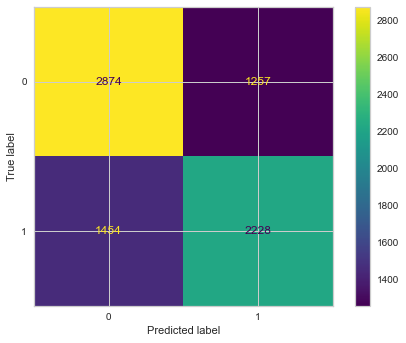

In [112]:
eval_train(X_train,y_train,logreg_model)

 Recall Score : 0.5998755444928439
 Precision Score : 0.6657458563535912
 F1 Score : 0.6310965630114567
 ROC-AUC Score : 0.6994138581671872


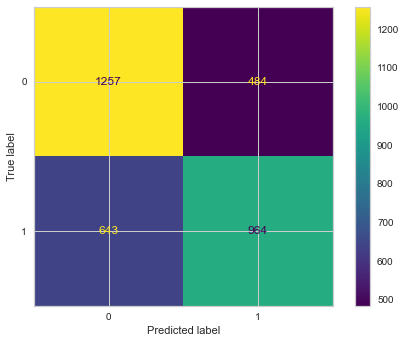

In [113]:
eval_test(X_test,y_test,logreg_model)

### 13.2 KNN

In [114]:
knn_model = KNeighborsClassifier()

 Recall Score : 0.652362846279196
 Precision Score : 0.7312024353120243
 F1 Score : 0.6895363858188602
 ROC-AUC Score : 0.7937585492817978


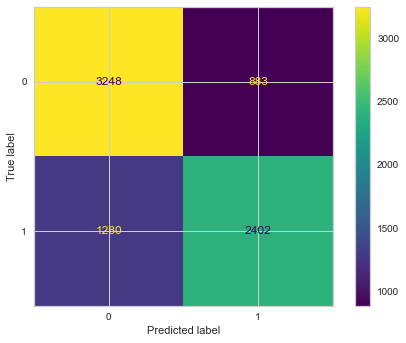

In [115]:
eval_train(X_train,y_train,knn_model)

 Recall Score : 0.5084007467330429
 Precision Score : 0.581081081081081
 F1 Score : 0.5423166279455691
 ROC-AUC Score : 0.6107457429747153


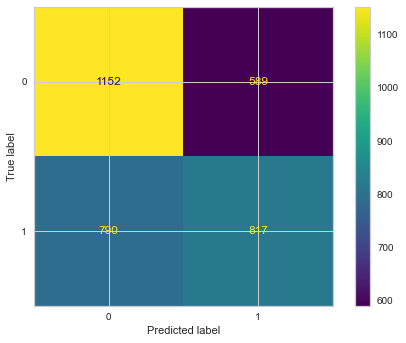

In [116]:
eval_test(X_test,y_test,knn_model)

### 13.3 Naive Bayes

In [117]:
naive = GaussianNB()

 Recall Score : 0.6827810972297664
 Precision Score : 0.6005733397037745
 F1 Score : 0.6390442297915607
 ROC-AUC Score : 0.685820082151999


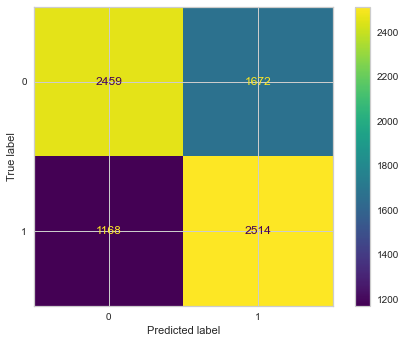

In [118]:
eval_train(X_train,y_train,naive)

 Recall Score : 0.6677037958929682
 Precision Score : 0.6075877689694225
 F1 Score : 0.6362288763711829
 ROC-AUC Score : 0.6862003790853272


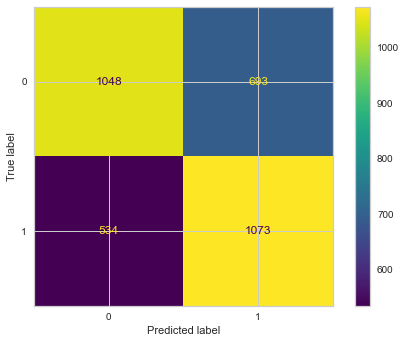

In [119]:
eval_test(X_test,y_test,naive)

### 13.4 Decision Tree

In [120]:
dt = DecisionTreeClassifier(random_state=42)

 Recall Score : 1.0
 Precision Score : 1.0
 F1 Score : 1.0
 ROC-AUC Score : 1.0


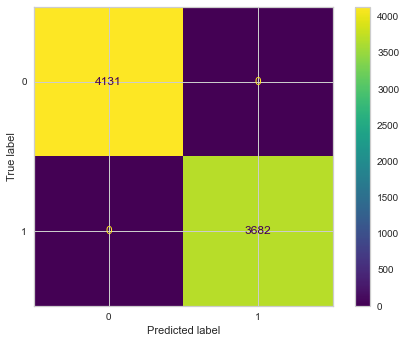

In [121]:
eval_train(X_train,y_train,dt)

 Recall Score : 0.6036092097075295
 Precision Score : 0.6085319949811794
 F1 Score : 0.606060606060606
 ROC-AUC Score : 0.6225972527572684


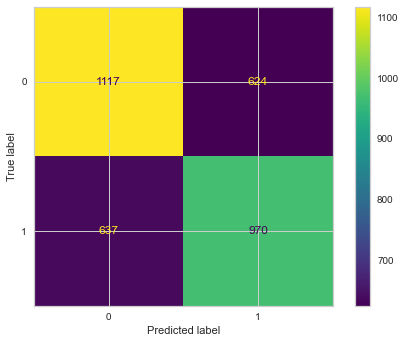

In [122]:
eval_test(X_test,y_test,dt)

###### Decision Tree - Hyperparameter Tuning

In [123]:
parameters = {
'criterion' : ('gini','entropy'),
'max_depth' : (5, 8,10, 15 ,20, 25, 30),
'min_samples_split' : (2, 5, 10, 15, 100),
'min_samples_leaf' : (1, 2, 5, 10,20,30)
}

gridD = RandomizedSearchCV(dt, parameters, cv =5, verbose = 1, 
                          n_iter=10)
bestD = gridD.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 Recall Score : 0.5736013036393265
 Precision Score : 0.7759000734753857
 F1 Score : 0.6595877576514678
 ROC-AUC Score : 0.7755642838274116


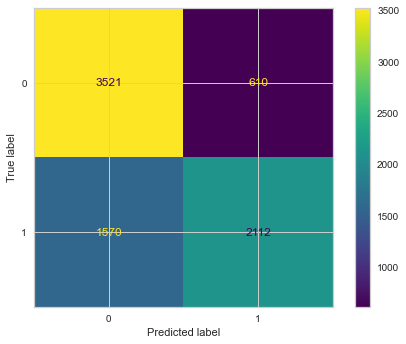

In [124]:
#menggunakan fungsi eval_test karna sudah difit dalam variable bestD
eval_test(X_train,y_train,bestD)

 Recall Score : 0.551337896701929
 Precision Score : 0.7631352282515074
 F1 Score : 0.6401734104046242
 ROC-AUC Score : 0.7461175564830347


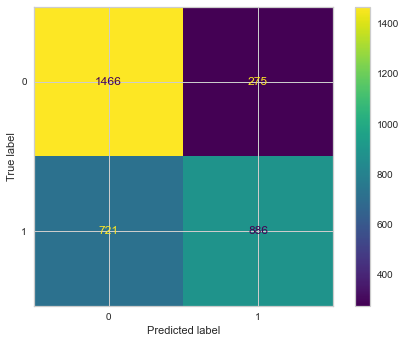

In [125]:
eval_test(X_test,y_test,bestD)

### 13.5 Random Forest

In [126]:
rf = RandomForestClassifier(random_state=42)

 Recall Score : 1.0
 Precision Score : 1.0
 F1 Score : 1.0
 ROC-AUC Score : 1.0


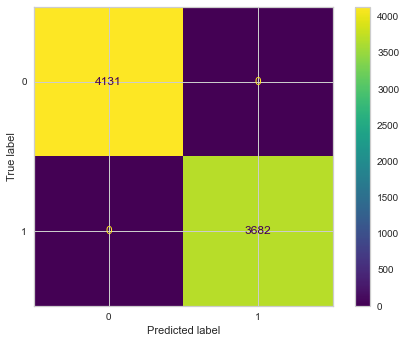

In [127]:
eval_train(X_train,y_train,rf)

 Recall Score : 0.5942750466708152
 Precision Score : 0.7420357420357421
 F1 Score : 0.6599861782999309
 ROC-AUC Score : 0.7558867061716993


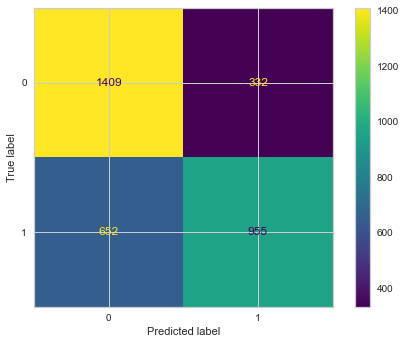

In [128]:
eval_test(X_test,y_test,rf)

###### Random Forest  - Hyperparameter Tuning

In [129]:
parameters = {
'n_estimators' : (100, 300, 500, 600, 800),
'max_depth' : (5, 8,10, 15 ,20, 25, 30),
'min_samples_split' : (2, 5, 10, 15, 100),
'min_samples_leaf' : (1, 2, 5, 10,20,30)
}

gridF = RandomizedSearchCV(rf, parameters, f, verbose = 1, 
                           n_iter=10)
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 Recall Score : 0.7381857686040195
 Precision Score : 0.8888162197514715
 F1 Score : 0.8065281899109792
 ROC-AUC Score : 0.9352199312809665


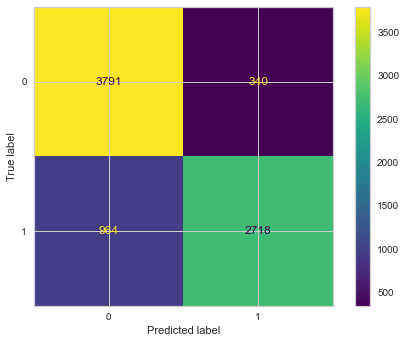

In [130]:
eval_test(X_train,y_train,bestF)

 Recall Score : 0.5799626633478532
 Precision Score : 0.7766666666666666
 F1 Score : 0.6640541503384396
 ROC-AUC Score : 0.7690510392678213


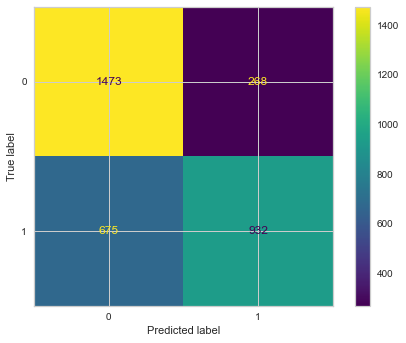

In [131]:
eval_test(X_test,y_test,bestF)

#### Observation
Dari ke 5 model diatas, model yang dipilih adalah Random Forest dengan Hyperparameter Tuning karna memiliki Precision paling tinggi yaitu 77.1%. Model ini mampu menangkap 932 nasabah yang sebenarnya subscribe deposit diantara 1200 nasabah pada data test yang diprediksi subscribe deposit. Dengan kata lain, model mampu meningkatkan conversion rate menjadi 77.6%

# Kesimpulan

## 14.1 Model Prediction

Model mampu menangkap 77.6% nasabah yang sebenarnya subscribe deposit dari semua nasabah yang diprediksi subscribe 

## 14.2 Recommendation

#### Target Nasabah
1. Kelompok Tua : usia 61+, seorang pensiunan, sudah menikah/belum, minimal jumlah balance 1400 dollar
2. Kelompok Muda : usia 21-30, bekerja di level management, belum menikah, minimal jumlah balance 450 dollar
<br/>

#### Pelaksanaan Campaign
1. Melaksanakan campaign pada bulan Januari, Februari, dan Maret (1Q).
2. Melaksanakan campaign via push notification dan email 1x pada minggu pertama disetiap bulan dengan tujuan awareness.
3. Melaksanakan campaign via telepon 1x pada minggu kedua disetiap bulan dengan tujuan conversion.